# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.
## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

In [1]:
import os, time
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.backend.clear_session() 

from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The argument num_words=10000 means you’ll only keep the top 10,000 most fre- quently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size. The variables train_data and test_data are lists of reviews; each review is a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [2]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]

1

In [4]:
# Because you’re restricting yourself to the top 10,000 most frequent words, no word index will exceed 10,000:
max([max(sequence) for sequence in train_data])

9999

Here’s how you can quickly decode one of these reviews back to English. Note that the indices
are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.

In [5]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])


## Data preparation
You can’t feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:
- Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices) , and then use as the first layer in your network 
- One-hot encode your lists to turn them into vectors of 0s and 1s. 

We will use the latter solution as it is the most common

In [6]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    """Creates an all-zero matrix of shape (len(sequences),dimension)"""

    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
        # Sets specific indices of results[i] to 1s
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [7]:
# Here’s what the samples look like now:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [8]:
# We should also vectorize your labels, which is straightforward:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
# Now the data is ready to be fed into a neural network.

## Model Architecture
There are two key architecture decisions to be made about such a stack of Dense layers:
- How many layers to use
- How many hidden units to choose for each layer

We are going to buils a model with the next configuration:
- A dense layer with 16 units, relu activated.
- A dense layer with 16 units, relu activated.
- A dense layer with 1 unit, sigmoid activated.


In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Compiling the model  
Finally, we need to choose a loss function and an optimizer. Because you’re facing a binary classification problem and the output of your network is a probability (you end your network with a single-unit layer with a sigmoid activation), it’s best to use the binary_crossentropy loss. 

In [10]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

In [11]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train, 
                    partial_y_train,
                    epochs=20, 
                    batch_size=512, 
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 126us/sample - loss: 0.5375 - binary_accuracy: 0.7718 - val_loss: 0.4099 - val_binary_accuracy: 0.8639
Epoch 2/20
15000/15000 [==============================] - 1s 63us/sample - loss: 0.3217 - binary_accuracy: 0.9005 - val_loss: 0.3226 - val_binary_accuracy: 0.8782
Epoch 3/20
15000/15000 [==============================] - 1s 62us/sample - loss: 0.2380 - binary_accuracy: 0.9232 - val_loss: 0.2828 - val_binary_accuracy: 0.8890
Epoch 4/20
15000/15000 [==============================] - 1s 61us/sample - loss: 0.1836 - binary_accuracy: 0.9415 - val_loss: 0.2782 - val_binary_accuracy: 0.8896
Epoch 5/20
15000/15000 [==============================] - 1s 62us/sample - loss: 0.1491 - binary_accuracy: 0.9529 - val_loss: 0.2826 - val_binary_accuracy: 0.8868
Epoch 6/20
15000/15000 [==============================] - 1s 63us/sample - loss: 0.1229 - binary_accuracy: 0.9626 - val_loss: 0.3046 -

If we name the fit , the result is a dictionary  that contains four entries: one per metric that was being monitored during training and during validation. In the following two listing, let’s use Matplotlib to plot the training and validation loss side by side as well as the training and validation accuracy . Note that your own results may vary slightly due to a different random initialization of your network. 

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

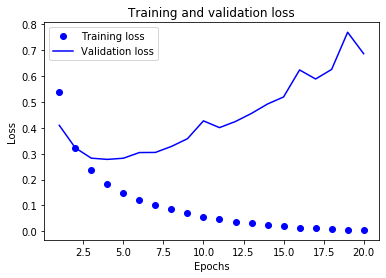

In [13]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 20 + 1) 
# “bo” is for “blue dot.”
plt.plot(epochs, loss_values, 'bo', label='Training loss')
#  “b” is for “solid blue line.”
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

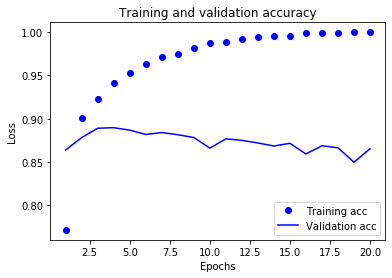

In [14]:
plt.clf()
# Clears the figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The final results are as follows:

In [15]:
results = model.evaluate(x_test, y_test, verbose = 0)
results

[0.7512154269409179, 0.8526]

### Using a trained network to generate predictions on new data

In [26]:
model.predict(x_test)

array([[2.0012856e-03],
       [9.9999946e-01],
       [9.8642147e-01],
       ...,
       [8.9058280e-04],
       [9.8682642e-03],
       [3.8380218e-01]], dtype=float32)

### Further experiments

- You used two hidden layers. Try using one or three hidden layers, and see how doing so affects validation and test accuracy.
- Try using layers with more hidden units or fewer hidden units: 32 units, 64 units, and so on.
- Try using the mse loss function instead of binary_crossentropy .
- Try using the tanh activation (an activation that was popular in the early days of neural networks) instead of relu .